In [1]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine

In [2]:
load_dotenv()
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [3]:
# Создадим соединения
src_conn = create_engine(f'postgresql://{src_username}:{src_password}@{src_host}:{src_port}/{src_db}')
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

In [4]:
sql_query = f"""
    SELECT *
    FROM users_churn
    """
#print(sql_query)
data = pd.read_sql(sql_query, dst_conn) #исполним написанный запрос
print(data.head())

   id customer_id begin_date   end_date            type paperless_billing  \
0  13  8091-TTVAX 2015-04-01        NaT        One year                No   
1  14  0280-XJGEX 2015-09-01 2019-10-01  Month-to-month               Yes   
2  15  5129-JLPIS 2018-01-01        NaT  Month-to-month               Yes   
3  17  3655-SNQYZ 2014-05-01        NaT        Two year                No   
4  19  9959-WOFKT 2014-03-01        NaT        Two year                No   

              payment_method  monthly_charges  total_charges internet_service  \
0    Credit card (automatic)           100.35        5681.10      Fiber optic   
1  Bank transfer (automatic)           103.70        5036.30      Fiber optic   
2           Electronic check           105.50        2686.05      Fiber optic   
3    Credit card (automatic)           113.25        7895.15      Fiber optic   
4  Bank transfer (automatic)           106.70        7382.25      Fiber optic   

   ... device_protection tech_support streaming_tv

In [5]:
# Анализ типов данных
features = data.drop(['customer_id','target'],axis=1)
data_types = features.dtypes.value_counts()
print(data_types)

object            14
int64              2
datetime64[ns]     2
float64            2
Name: count, dtype: int64


In [6]:
num_features = features.select_dtypes(include=['float', 'int'])
date_features = features.select_dtypes(include='datetime64[ns]')
cat_features = features.select_dtypes(include='object') 

In [7]:
unique_values_per_col = cat_features.nunique()
print(unique_values_per_col.value_counts())

2    12
3     1
4     1
Name: count, dtype: int64


12 категориальных признаков имеют только 2 уникальных значения - бинарные признаки

In [8]:
binary , nobinary = [] , []
for col in cat_features.columns:
    if cat_features[col].nunique() == 2:
        binary.append(col)
    else:
        nobinary.append(col)
binary_cat_features = cat_features[binary]
other_cat_features = cat_features[nobinary]

print(binary_cat_features.head(2))
print(other_cat_features.head(2))

  paperless_billing internet_service online_security online_backup  \
0                No      Fiber optic              No            No   
1               Yes      Fiber optic              No           Yes   

  device_protection tech_support streaming_tv streaming_movies gender partner  \
0               Yes           No          Yes              Yes   Male     Yes   
1               Yes           No          Yes              Yes   Male      No   

  dependents multiple_lines  
0         No            Yes  
1         No            Yes  
             type             payment_method
0        One year    Credit card (automatic)
1  Month-to-month  Bank transfer (automatic)


In [9]:
import numpy as np
yes_no , other_binary = [] , []
for col in binary_cat_features.columns:
    if all(binary_cat_features[col].isin(['Yes','No',None,np.nan])):
        yes_no.append(col)
    else:
        other_binary.append(col)

yes_no_features = binary_cat_features[yes_no]
other_binary_features = binary_cat_features[other_binary]
print(yes_no_features.head())

  paperless_billing online_security online_backup device_protection  \
0                No              No            No               Yes   
1               Yes              No           Yes               Yes   
2               Yes             Yes            No               Yes   
3                No             Yes           Yes               Yes   
4                No             Yes            No               Yes   

  tech_support streaming_tv streaming_movies partner dependents multiple_lines  
0           No          Yes              Yes     Yes         No            Yes  
1           No          Yes              Yes      No         No            Yes  
2          Yes          Yes              Yes      No         No             No  
3          Yes          Yes              Yes     Yes        Yes            Yes  
4           No          Yes              Yes      No        Yes            Yes  


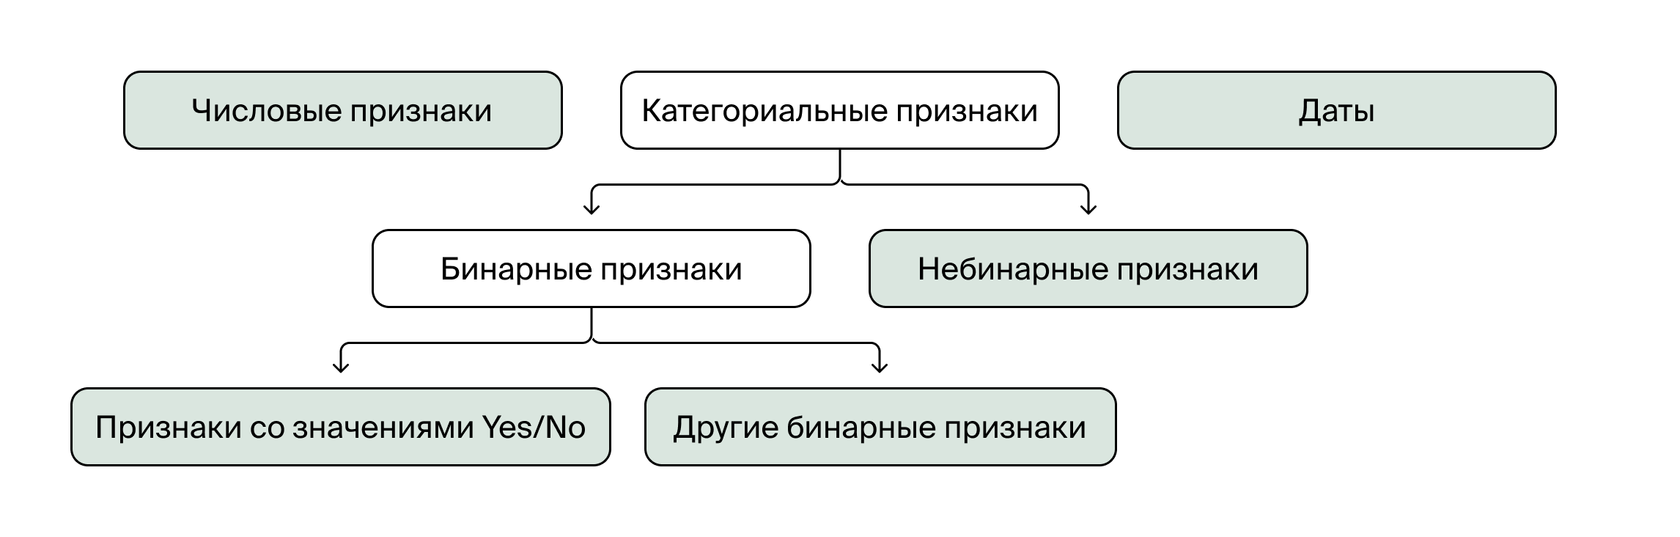

Числовые признаки

In [10]:
num_features.head() 

,id,monthly_charges,total_charges,senior_citizen
0,13,100.35,5681.10,0
1,14,103.70,5036.30,0
2,15,105.50,2686.05,0
3,17,113.25,7895.15,0
4,19,106.70,7382.25,0


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

<Axes: xlabel='monthly_charges', ylabel='Count'>

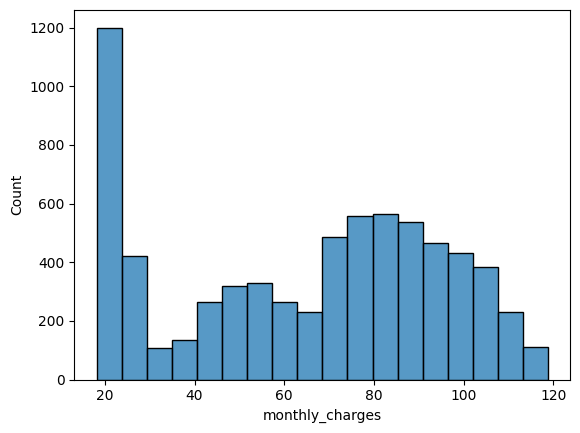

In [11]:
import seaborn as sns
display(num_features['monthly_charges'].describe())
display(sns.histplot(num_features['monthly_charges'])) 

Заметно, что среди клиентов наиболее распространён самый недорогой тариф за 18,25 долларов. При этом достаточно большие группы клиентов составляют стандартный и премиальный пакет, причём последний преобладает. 

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: total_charges, dtype: float64

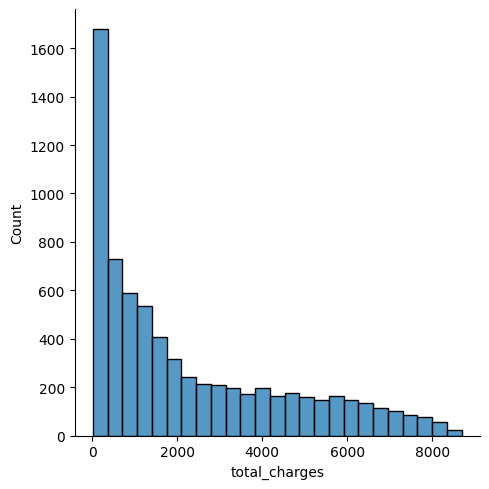

In [13]:
display(num_features['total_charges'].describe())
display(sns.displot(num_features['total_charges'])) 

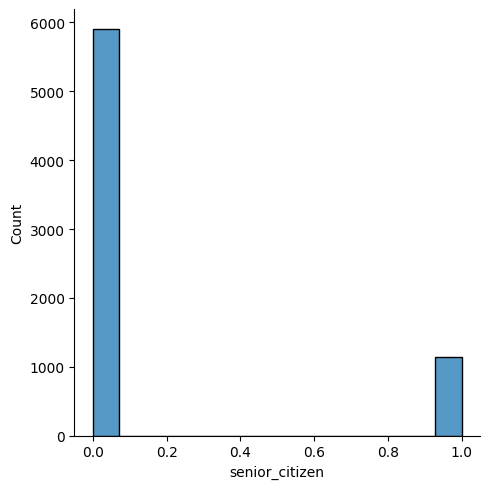

In [14]:
sns.displot(num_features['senior_citizen']) 

Категориальные небинарные признаки

In [15]:
other_cat_features.head()

,type,payment_method
0,One year,Credit card (automatic)
1,Month-to-month,Bank transfer (automatic)
2,Month-to-month,Electronic check
3,Two year,Credit card (automatic)
4,Two year,Bank transfer (automatic)


<Axes: xlabel='count', ylabel='type'>

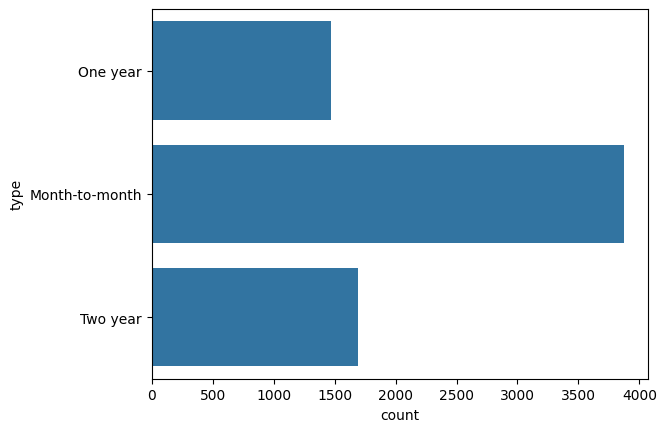

In [16]:
sns.countplot(other_cat_features['type']) 

<Axes: xlabel='count', ylabel='payment_method'>

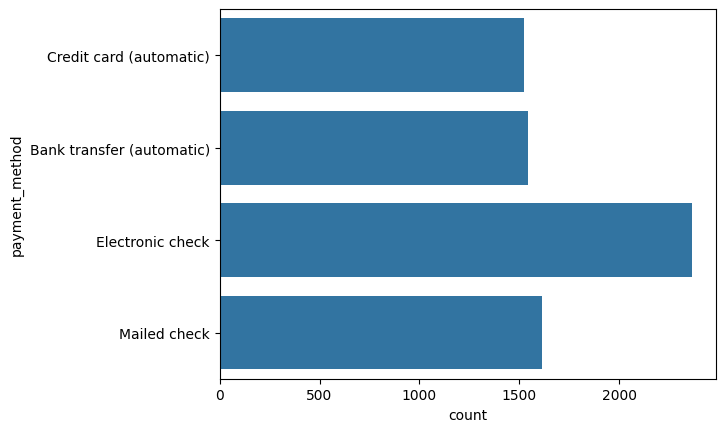

In [17]:
sns.countplot(other_cat_features['payment_method'])

Бинарные признаки со значениями Yes и No

In [19]:
yes_no_features 

,paperless_billing,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,partner,dependents,multiple_lines
0,No,No,No,Yes,No,Yes,Yes,Yes,No,Yes
1,Yes,No,Yes,Yes,No,Yes,Yes,No,No,Yes
2,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No
3,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,No,Yes,No,Yes,No,Yes,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...
7038,Yes,None,None,None,None,None,None,Yes,Yes,Yes
7039,No,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes
7040,Yes,No,Yes,No,Yes,No,Yes,Yes,Yes,No
7041,Yes,No,Yes,No,No,No,No,Yes,No,No


Другие бинарные признаки

In [18]:
other_binary_features.head() 

,internet_service,gender
0,Fiber optic,Male
1,Fiber optic,Male
2,Fiber optic,Male
3,Fiber optic,Female
4,Fiber optic,Male


<Axes: xlabel='count', ylabel='internet_service'>

<Axes: xlabel='count', ylabel='internet_service'>

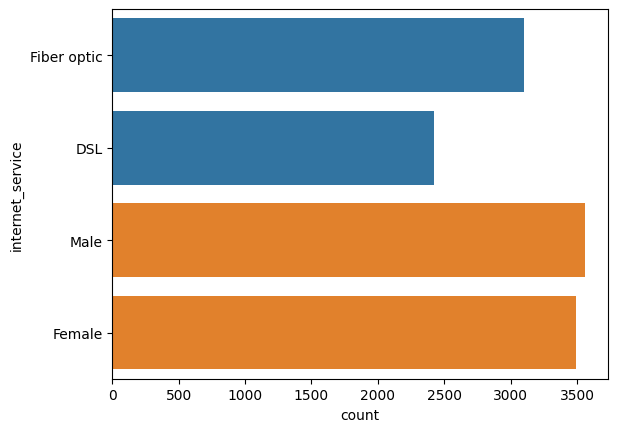

In [20]:
display(sns.countplot(other_binary_features['internet_service']))
display(sns.countplot(other_binary_features['gender'])) 

Даты

In [21]:
date_features.head()

,begin_date,end_date
0,2015-04-01,NaT
1,2015-09-01,2019-10-01
2,2018-01-01,NaT
3,2014-05-01,NaT
4,2014-03-01,NaT


In [22]:
date_features['begin_date'].describe()

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: begin_date, dtype: object